## Introduction

In this workshop, we will dive into a construction of a simple MultiLayer Perceptron neural network. A MultiLayer Perceptron, also termed MLP, is a simple network consisting of a few fully connected linear layers separated by nonlinear components (also called *activation functions*). A nonlinear component in-between the linear layers is essential: without it, a compostion of linear components would be just a linear component, so a multilayer network would be equivalent to a single layered network. Also, please note that it is a nonlinear component that enables a neural network to express nonlinear functions, too.

In this workshop, we will construct an MLP network designed to a specific task of classification of MNIST dataset: a set of handwritten digits 0-9. You can read more about this dataset here: https://colah.github.io/posts/2014-10-Visualizing-MNIST/#MNIST

MNIST stands for Modified National Institute of Standards and Technology database.

In [1]:
import torch
import torchvision
from matplotlib import pyplot

### Reading MNIST data set

In [2]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=None)

/home/snowakowski/venv/jupyter/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


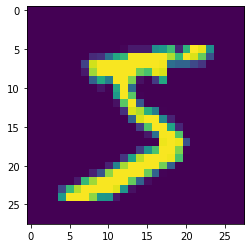

In [3]:
train_image, train_target = trainset[0]    #let us examine the 0-th sample
pyplot.imshow(train_image)
pyplot.show()

In [4]:
trainset.data[0]     #it will be shown in two rows, so a human has hard time classificating it

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [5]:
train_target    #check if you classified it correctly in your mind

5

### Your task #1

Examine a few more samples from mnist dataset. Try to guess the correct class correctly, classifing images with your human classification skills. Try to estimate the accuracy, i.e. what is your percentage of correct classifications - treating a training set that we are examining now as a test set for you. It is sound, because you have not trained on that set before attempting the classification.

### Your task #2

Try to convert the dataset into numpy `ndarray`. Then estimate mean and standard deviation of MNIST dataset. Please remember that it is customary to first divide each value in MNIST dataset by 255, to normalize the initial pixel RGB values 0-255 into (0,1) range.

*Tips:* 
- to convert MNIST dataset to numpy, use `trainset.data.numpy()`
- in numpy, there are methods `mean()` and `std()` to calculate statistics of a vector. 

Now, we will reread the dataset (**train** and **test** parts) and transform it (standardize it) so it will be zero-mean and unit-std. 

In [6]:
transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
      torchvision.transforms.Normalize((0.1307), (0.3081))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=2048, shuffle=True)   #we do shuffle it to give more randomizations to training epochs

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)

Let us visualise the training labels

In [7]:
for i, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        if i<5:
            print(i, "-th batch labels :", batch_labels)

0 -th batch labels : tensor([2, 5, 9,  ..., 7, 2, 3])
1 -th batch labels : tensor([5, 9, 3,  ..., 4, 7, 7])
2 -th batch labels : tensor([2, 8, 8,  ..., 9, 9, 8])
3 -th batch labels : tensor([4, 1, 1,  ..., 6, 7, 1])
4 -th batch labels : tensor([0, 1, 1,  ..., 8, 0, 8])


### Your taks #3

Labels are entities of order zero (constants), but batched labels are of order one. The first (and only) index is a sample index within a batch. 

Your task is to visualise and inspect the number of orders in data in batch_inputs.

OK, so each data image was initially a two dimensional image when we first saw it, but now the batches have order 4. The first index is a sample index within a batch, but a second index is always 0. This index represents a Channel number inserted here by ToTensor() transformation, always 0. As this order is one-dimensional, we can get rid of it, later, in training, in `Flatten()` layer or by using `squeeze()` on a tensor.

### MLP

Now, a definition of a simple MLP network.

In [8]:
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.mlp = torch.nn.Sequential(   #Sequential is a structure which allows stacking layers one on another in such a way, 
                                          #that output from a preceding layer serves as input to the next layer 
            torch.nn.Flatten(),   #change the last three orders in data (with dimensions 1, 28 and 28 respectively) into one order of dimensions (1*28*28)
            torch.nn.Linear(1*28*28, 1024),  #which is used as INPUT to the first Linear layer
            torch.nn.Sigmoid(),
            torch.nn.Linear(1024, 2048),   #IMPORTANT! Please observe, that the OUTPUT dimension of a preceding layer is always equal to the INPUT dimension of the next layer.
            torch.nn.Sigmoid(),
            torch.nn.Linear(2048, 256),
            torch.nn.Sigmoid(),            #Sigmoid is a nonlinear function which is used in-between layers
            torch.nn.Linear(256, 10),
        )
    def forward(self, x):
        out = self.mlp(x)
        return out
    


### Training

Training consists of 
- an initiation of a network
- a definition of an optimizer. Optimizer does a gradient descent on gradients computed in a `backward()` step on a loss.
- running through multiple epochs and updating the network weights

In [ ]:
net = MLP()
optimizer = torch.optim.Adam(net.parameters(), 0.001)   #initial and fixed learning rate of 0.001. We will be using ADAM optimizer throughout the workshop
                                                        #different choices are possible, but this is outside the scope of this workshop

net.train()    #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing traning
for epoch in range(8):  #  an epoch is a training run through the whole data set

    loss = 0.0
    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data
        #batch_inputs.squeeze(1)     #alternatively if not for a Flatten layer, squeeze() could be used to remove the second order of the tensor, the Channel, which is one-dimensional (this index can be equal to 0 only)
        
        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)   #this line calls the forward(self, x) method of the MLP object. Please note, that the last layer of the MLP is linear 
                                            #and MLP doesn't apply 
                                            #the nonlinear activation after the last layer
        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function
        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item()) 
        loss.backward()       #this computes gradients as we have seen in previous workshops
        optimizer.step()     #but this line in fact updates our neural network. 
                                ####You can experiment - comment this line and check, that the loss DOES NOT improve, meaning that the network doesn't update


epoch: 0 batch: 0 current batch loss: 2.345842123031616
epoch: 0 batch: 1 current batch loss: 2.410470724105835
epoch: 0 batch: 2 current batch loss: 2.386631488800049
epoch: 0 batch: 3 current batch loss: 2.3326854705810547
epoch: 0 batch: 4 current batch loss: 2.2959706783294678
epoch: 0 batch: 5 current batch loss: 2.2800686359405518
epoch: 0 batch: 6 current batch loss: 2.259901762008667
epoch: 0 batch: 7 current batch loss: 2.2586305141448975
epoch: 0 batch: 8 current batch loss: 2.2351584434509277
epoch: 0 batch: 9 current batch loss: 2.1836163997650146
epoch: 0 batch: 10 current batch loss: 2.1334941387176514
epoch: 0 batch: 11 current batch loss: 2.0596354007720947
epoch: 0 batch: 12 current batch loss: 1.9855166673660278
epoch: 0 batch: 13 current batch loss: 1.916955828666687
epoch: 0 batch: 14 current batch loss: 1.8230472803115845
epoch: 0 batch: 15 current batch loss: 1.7361259460449219
epoch: 0 batch: 16 current batch loss: 1.6495928764343262
epoch: 0 batch: 17 current ba

### Your task #4

Comment the line `optimizer.step()` above. Rerun the above code. Note that the loss is NOT constant as the comment in the code seems to promise, but anyway, the loss doesn't improve, either. Please explain, why the loss is not constant. Please explain, why the loss doesn't improve, either.

### Training - the second approach


Sometimes during training loss stabilizes and doesn't improve anymore. It is not the case here (yet, but we have only run 8 epochs), but a real problem in practice.
We can include a new tool called a **scheduler** that would update the *learning rate* in an otpimizer after each epoch. This usually helps the training. Let us reformulate the traning so it consists of 
- an initiation of a network
- a definition of an optimizer. Optimizer does a gradient descent on gradients computed in a `backward()` step on a loss.
- a definition of a scheduler to update the learning rate in an optimizer
- running through multiple epochs and updating the network weights

In [ ]:
net_with_scheduler = MLP()
optimizer = torch.optim.Adam(net_with_scheduler.parameters(), 0.001)   #initial learning rate of 0.001. 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)    #updates the learning rate after each epoch. There are many ways to do that: StepLR multiplies learning rate by gamma

net_with_scheduler.train()    #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing traning
for epoch in range(8):  #  an epoch is a training run through the whole data set

    loss = 0.0
    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data
        #batch_inputs.squeeze(1)     #alternatively if not for a Flatten layer, squeeze() could be used to remove the second order of the tensor, the Channel, which is one-dimensional (this index can be equal to 0 only)
        
        optimizer.zero_grad()

        batch_outputs = net_with_scheduler(batch_inputs)   #this line calls the forward(self, x) method of the MLP object. Please note, that the last layer of the MLP is linear 
                                            #and MLP doesn't apply 
                                            #the nonlinear activation after the last layer
        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function
        
        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item(), "current lr:", scheduler.get_last_lr()[0]) 
        loss.backward()       #this computes gradients as we have seen in previous workshops
        optimizer.step()     #but this line in fact updates our neural network. 
                                
    scheduler.step()

### Your task #5

Well, it seems that we were able to get the learning rate much below 0.1 even without a scheduler. Can you bring it under 0.05? Can you keep it under 0.05? Maybe the proposed gamma was to low (0.9 only)?. Please experiment with different settings for the optimizer learning rate and different scheduler settings. Ask the workshop trainer, there are other schedulers you can experiment with, too. Please verify what would happen if the nets were allowed to train for more training epochs.

Some other schedulers you might want to experiment with: 
- Exponential LR - decays the learning rate of each parameter group by gamma every epoch - [link to documentation](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR.html) 
- Step LR - more general then the Exponential LR: decays the learning rate of each parameter group by gamma every step_size epochs - [link to documentation](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html)
- Cosine Annealing LR - learning rate follows the first quarter of the cosine curve - [link to documentation](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html)
- Cosine with Warm Restarts - learning rate follows the first quarter of the cosine curve and restarts after a predefined number of epochs - [link to documentation](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingWarmRestarts.html)

### Your task #6

Please explain, what are the dangers of bringing the loss too low? What is an *overtrained* neural network? How can one prevent it?

### Testing

Now we will test those two nets - the one without and the one with the scheduler.

In [ ]:
good = 0
wrong = 0

net.eval()              #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing evaluation
with torch.no_grad():   #it prevents that the net learns during evalution. The gradients are not computed, so this makes it faster, too
    for batch, data in enumerate(testloader): #batches in test are of size 1
        datapoint, label = data

        prediction = net(datapoint)                  #prediction has values representing the "prevalence" of the corresponding class
        classification = torch.argmax(prediction)    #the class is the index of maximal "prevalence"

        if classification.item() == label.item():
            good += 1
        else:
            wrong += 1
        
print("accuracy = ", good/(good+wrong))

In [ ]:
good = 0
wrong = 0

net_with_scheduler.eval()   #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing evaluation
with torch.no_grad():       #it prevents that the net learns during evalution. The gradients are not computed, so this makes it faster, too
    for batch, data in enumerate(testloader): #batches in test are of size 1

        datapoint, label = data

        prediction = net_with_scheduler(datapoint)                  #prediction has values representing the "prevalence" of the corresponding class
        classification = torch.argmax(prediction)                   #the class is the index of maximal "prevalence"

        if classification.item() == label.item():
            good += 1
        else:
            wrong += 1
        
print("accuracy = ", good/(good+wrong))

Well, not bad. Now it is your turn to experiment - change the number and sizes of layers in out neural networks, change the activation function, play with the learning rate and the optimizer and the scheduler.